Create a LSTM model that takes in processsed EEG data of 5x90x1 matrix. There are 5 EEG channels recording per sample. There are 90 because there are 90 different bins from 0.5 - 40 Hz from fourier transform.

In [10]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import os

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#Get data directory

data_dir = "/content/gdrive/My Drive/APS360/APS360_project/ProcessedInputData"

In [12]:
#Load Data
#Train
X_train = np.load(data_dir + '/X_train.npy')
y_train = np.load(data_dir + '/y_train.npy')

#Val
X_val = np.load(data_dir + '/X_val.npy')
y_val = np.load(data_dir + '/y_val.npy')

#Test
X_test = np.load(data_dir + '/X_test.npy')
y_test = np.load(data_dir + '/y_test.npy')

#Convert to PyTorch Tensor
X_train_tensor = torch.from_numpy(X_train)
Y_train_tensor = torch.from_numpy(y_train)
X_val_tensor = torch.from_numpy(X_val)
Y_val_tensor = torch.from_numpy(y_val)

X_test_tensor = torch.from_numpy(X_test)
Y_test_tensor = torch.from_numpy(y_test)

# Create a DataLoader for batching
batch_size = 64

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)



In [30]:
#Print the shape of data
print("Shape of X_train_tensor:", X_train_tensor.shape)
print("Shape of Y_train_tensor:", Y_train_tensor.shape)

# Print the first few elements of the tensors
print("\nFirst few elements of Y_train_tensor:")
print(Y_train_tensor.size())
print(Y_train_tensor[:10])  # Print first 10 elements

print("First few elements of X_train_tensor:")
print(X_train_tensor.size())
# print(X_train_tensor[:3])  # Print first 3 elements

# each input is 5x90x1 matrix
# 5 bc there are 5 eeg channels recordings per sample,
# 90 bc i did fourier transform and binned it into 90 different bins from 0.5 to 40 Hz (relevant frequencies for EEG)
# the 1 was added just to be the dimension of picture style for CNN so its like black and white

print("Val tensors:")
print(Y_val_tensor.size())
print(X_val_tensor.size())




(3153, 5, 90, 1)
Shape of X_train_tensor: torch.Size([3153, 5, 90, 1])
Shape of Y_train_tensor: torch.Size([3153])

First few elements of Y_train_tensor:
torch.Size([3153])
tensor([1, 1, 1, 1, 0, 0, 0, 1, 0, 0])
First few elements of X_train_tensor:
torch.Size([3153, 5, 90, 1])
Val tensors:
torch.Size([394])
torch.Size([394, 5, 90, 1])


In [18]:
#Create a dataset for sanity check:
sanity_train_dataset = TensorDataset(X_train_tensor[:100], Y_train_tensor[:100])
sanity_train_loader = DataLoader(sanity_train_dataset, batch_size=batch_size, shuffle=True)
sanity_val_dataset = TensorDataset(X_val_tensor[:100], Y_val_tensor[:100])
sanity_val_loader = DataLoader(sanity_val_dataset, batch_size=batch_size, shuffle=False)

In [73]:
#Building LSTM Model

class LSTM(nn.Module):
  '''
  This model architecture is based on the approach outlined in
  [LieWaves: dataset for lie detection based on EEG signals and wavelets,
  Musa Aslan, Muhammet Baykara & Talha Burak Alak, 2024].
  The model consists of three fully connected
  layers with ReLU activations and dropout for regularization.
  '''
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.name = 'lstm'
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    self.fc1 = nn.Linear(hidden_size, 32) #hidden_size = 64
    self.fc2 = nn.Linear(32, 4)
    self.fc3 = nn.Linear(4, 1) #Output layer
    self.relu = nn.ReLU()

    self.dropout = nn.Dropout(0.5)
    self.dropout2 = nn.Dropout(0.4)
    self.dropout3 = nn.Dropout(0.3)

  def forward(self, x):
    batch_size = x.size(0)
    x = x.view(batch_size, 90, 5)
    x = x.to(torch.float32)
    #print(x.size())
    h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
    c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
    #h0 = torch.zeros(self.num_layers, self.hidden_size)  # Instead of (num_layers, batch_size, hidden_size)
    #c0 = torch.zeros(self.num_layers, self.hidden_size)
    out, _ = self.lstm(x, (h0, c0))
    out = out[:, -1, :]  # Take the output from the last time step
    out = torch.relu(self.fc1(out))
    out = self.dropout(out)
    out = torch.relu(self.fc2(out))
    out = self.dropout2(out)
    out = torch.relu(self.fc3(out))
    out = self.dropout3(out)
    return out



In [74]:
#Other functions:

#They are all from lab 2
def get_model_name(name, batch_size, learning_rate, epoch):
  path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                 batch_size,
                                                 learning_rate,
                                                 epoch)
  return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
  """ Evaluate the network on the validation set.

    Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
    Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
  """
  total_loss = 0.0
  total_err = 0.0
  total_epoch = 0
  for i, data in enumerate(loader, 0):
      inputs, labels = data
      labels = labels.view(-1,1)
      labels = labels.float()

      labels = normalize_label(labels)  # Convert labels to 0/1
      outputs = net(inputs)
      loss = criterion(outputs, labels.float())
      corr = (outputs > 0.0).squeeze().long() != labels
      total_err += int(corr.sum())
      total_loss += loss.item()
      total_epoch += len(labels)
  err = float(total_err) / total_epoch
  loss = float(total_loss) / (i + 1)

  return err, loss

def plot_training_curve(path):
  """ Plots the training curve for a model run, given the csv files
      containing the train/validation error/loss.

  Args:
      path: The base path of the csv files produced during training
  """
  import matplotlib.pyplot as plt
  train_err = np.loadtxt("{}_train_err.csv".format(path))
  val_err = np.loadtxt("{}_val_err.csv".format(path))
  train_loss = np.loadtxt("{}_train_loss.csv".format(path))
  val_loss = np.loadtxt("{}_val_loss.csv".format(path))
  plt.title("Train vs Validation Error")
  n = len(train_err) # number of epochs
  plt.plot(range(1,n+1), train_err, label="Train")
  plt.plot(range(1,n+1), val_err, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Error")
  plt.legend(loc='best')
  plt.show()
  plt.title("Train vs Validation Loss")
  plt.plot(range(1,n+1), train_loss, label="Train")
  plt.plot(range(1,n+1), val_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()


In [75]:
#Training model

def train_net(model, train_loader,val_loader, batch_size=64, learning_rate=0.01, num_epochs=30):
  #Set to training mode
  model.train()

  #Loss and optimizer
  criterion = nn.BCEWithLogitsLoss() # The loss function will be Binary Cross Entropy (BCE)
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # Optimizer will be SGD with Momentum.

  # Set up some numpy arrays to store the training/test loss/erruracy
  train_err = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)

  start_time = time.time()

  for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_train_err = 0.0
    total_epoch = 0

    for i, data in enumerate(train_loader, 0): #change this train_loader for an actual training
      #Get the inputs and labels
      inputs, labels = data

      labels = labels.view(-1,1) # Ensure y has the shape (batch_size, 1)
      #print(labels.size())
      labels = labels.float()

      ## Forward pass, backward pass, and optimize
      optimizer.zero_grad()#Zero the parameter gradients

      output = model(inputs) # Forward
      loss = criterion(output, labels) # Calculate loss
      loss.backward() # Backpropagate
      optimizer.step() # Update weights

      # Calculate the statistics
      corr = (torch.sigmoid(output) > 0.5).long() != labels.long()
      total_train_err += int(corr.sum())
      total_train_loss += loss.item()
      total_epoch += len(labels)

      train_err[epoch] = float(total_train_err) / total_epoch
      train_loss[epoch] = float(total_train_loss) / (i+1)
      val_err[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion) #change to val_loader for an actual training
      print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))

      # Save the current model (checkpoint) to a file
      model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
      torch.save(model.state_dict(), model_path)
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
  # Write the train/test loss/err into CSV file for plotting later
  epochs = np.arange(1, num_epochs + 1)
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)







In [76]:
#Run the training
lr = 0.001
num_epochs = 30

lstm = LSTM(input_size=5, hidden_size=64, num_layers=2)
train_net(model=lstm, train_loader=sanity_train_loader, val_loader=sanity_train_loader, batch_size=64, learning_rate=lr, num_epochs = num_epochs)


Epoch 1: Train err: 0.5, Train loss: 0.6957778334617615 |Validation err: 26.96, Validation loss: 0.6857467591762543
Epoch 1: Train err: 0.51, Train loss: 0.7021048367023468 |Validation err: 26.94, Validation loss: 0.6937462091445923
Epoch 2: Train err: 0.375, Train loss: 0.6905872821807861 |Validation err: 26.6, Validation loss: 0.6995163261890411
Epoch 2: Train err: 0.44, Train loss: 0.6995383203029633 |Validation err: 27.08, Validation loss: 0.6989095211029053
Epoch 3: Train err: 0.4375, Train loss: 0.697821319103241 |Validation err: 26.96, Validation loss: 0.7042650878429413
Epoch 3: Train err: 0.47, Train loss: 0.7022057175636292 |Validation err: 26.96, Validation loss: 0.7025092244148254
Epoch 4: Train err: 0.46875, Train loss: 0.6925855278968811 |Validation err: 26.6, Validation loss: 0.7032075524330139
Epoch 4: Train err: 0.49, Train loss: 0.6981096565723419 |Validation err: 26.96, Validation loss: 0.6999349296092987
Epoch 5: Train err: 0.609375, Train loss: 0.7068983912467957 |

In [72]:
#Delete csv so we can run the code again
for i in range(30):
  os.remove(f"/content/model_lstm_bs{batch_size}_lr{lr}_epoch{i}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/model_lstm_bs64_lr0.001_epoch15'

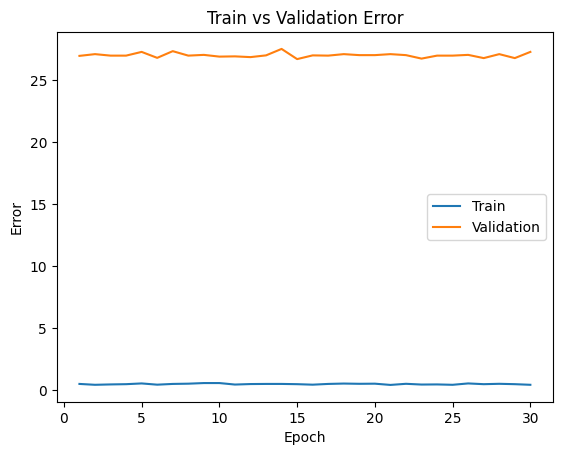

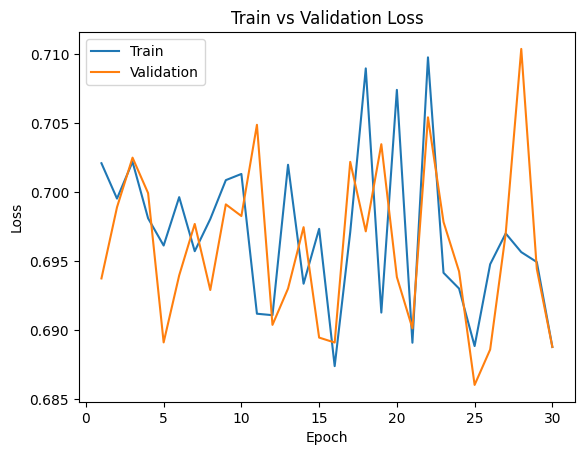

In [83]:
model_path = get_model_name('lstm', batch_size=64, learning_rate=lr, epoch=num_epochs-1)
plot_training_curve(model_path)